# Import libraries

In [88]:
import numpy as np
import uproot as up
import awkward as ak
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd
import pandas as pd
import mplhep as hep
hep.style.use("CMS")

# Load data

In [189]:
class Jet:

    required_variables = ["pt", "eta", "mass", "genpt", "genmass", "event"]    # variables required for the class to function
    l1_vars = ["pt", "eta", "mass"]    # variables to bin on
    # l1_vars = ["pt", "eta"]    # variables to bin on
    
    def __init__(self, path: str, branch: str = "outnano/Jets",
                 keys: dict = {"jet_pt": "pt", "jet_eta_phys": "eta", "jet_mass": "mass", "jet_genmatch_pt": "genpt", "jet_genmatch_mass": "genmass", "event": "event"}):
        for v in Jet.required_variables:
            if v not in list(keys.values()): raise Exception("A required variable is not defined in keys!")
        self.data = self.load(path, branch, keys)


    @staticmethod
    def load(path, branch, keys):
        print("Loading data...")
        with up.open(path)[branch] as file:
            data = file.arrays( filter_name=list( keys.keys() ) )
            reject_mask = file["jet_reject"].array() == False if "jet_reject" in file.keys() else ak.ones_like(data["event"], dtype=bool)
        
        data = ak.Array({keys[field]: data[field] for field in data.fields})[reject_mask]
        print("Data loaded!\n")
        return data


    @staticmethod
    def preprocess(data, eta_limit: int = 5.0, l1_pt_range: tuple[float, float] = (0., 1000.), l1_mass_range: tuple[float, float] = (0., 182.),
                   gen_pt_range: tuple[float, float] = (0., 1000.), gen_mass_range: tuple[float, float] = (0., 182.)
                   ) -> ak.highlevel.Array:
        
        # clip L1 masses to the same range as gen
        # data["pt"] = np.clip(data["pt"], a_min = l1_pt_range[0], a_max = l1_pt_range[1])
        # data["mass"] = np.clip(data["mass"], a_min = l1_mass_range[0], a_max = l1_mass_range[1])

        # filter out gen masses outside of range
        mask = (data["genmass"] > gen_mass_range[0]) & (data["genmass"] < gen_mass_range[1])
        mask = mask & ( data["genpt"] > gen_pt_range[0]) & (data["genpt"] < gen_pt_range[1] )
        mask = mask & ( (data["pt"] > 5) & (data["mass"] > 1) )

        mask = mask & (abs(data["eta"]) < eta_limit)

        return data[mask]
    

    @staticmethod
    def test_train_split(data, train_ratio = 0.75):
        data = data[ np.random.permutation(len(data)) ]
        splitIdx = int(len(data) * train_ratio)
        data_train, data_test = data[:splitIdx], data[splitIdx:]
        return data_train, data_test
    

    @staticmethod
    def response(data_train, eps = 1e-6):
        pt_response = (data_train["pt"] + eps) / (data_train["genpt"] + eps)
        mass_response = (data_train["mass"] + eps) / (data_train["genmass"] + eps)
        return pt_response, mass_response
    

    @staticmethod
    def histogram( data_train: ak.highlevel.Array, pt_response: ak.highlevel.Array, mass_response: ak.highlevel.Array,
        nBins: int = 100, nans: int = 1, how: str = "mean" ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

        bin_edges = []
        vals = []
        for v in Jet.l1_vars:
            if (v == "pt") | (v=="mass"):
                values = ak.to_numpy(data_train[v])
                vals.append( values )
                bin_edges.append( np.unique( np.quantile(values, np.linspace(0, 1, nBins + 1)) ) )
            elif v == "eta":
                vals.append( ak.to_numpy(data_train["eta"]) )
                bin_edges.append( np.linspace(-5, 5, 11) )
            else:
                raise Exception("Invalid variable in l1_vars!")

        train_numpy = np.column_stack(vals)

        # bins = [nBins] * len(Jet.l1_vars)
        # bin_edges = []
        # for i, var in enumerate(Jet.l1_vars):
        #     values = ak.to_numpy(data_train[var])
        #     edges = np.quantile(values, np.linspace(0, 1, nBins + 1))
        #     edges = np.unique(edges)
        #     bin_edges.append(edges)
        # train_numpy = np.column_stack( [ ak.to_numpy(data_train[l1_var]) for l1_var in Jet.l1_vars ] )    # convert to numpy for scipy binned stats dd

        pt_resp = binned_statistic_dd( train_numpy, ak.to_numpy(pt_response), statistic = how, bins = bin_edges )[0]
        mass_resp = binned_statistic_dd( train_numpy, ak.to_numpy(mass_response), statistic = how, bins = bin_edges )[0]

        counts = binned_statistic_dd(
            train_numpy, np.ones(len(train_numpy)),
            statistic='count', bins=bin_edges
        )[0]
        
        pt_sf = 1 / np.nan_to_num(pt_resp, nan=nans)
        mass_sf = 1 / np.nan_to_num(mass_resp, nan=nans)
        return pt_sf, mass_sf, pt_resp, mass_resp, bin_edges, counts
    

    @staticmethod
    def apply_scale_factors(data_test, pt_scalefactors, mass_scalefactors, bin_edges):

        # bin_idx = [ np.digitize(data_test[Jet.l1_vars[i]], bin_edges[i]) - 1 for i in range(len(Jet.l1_vars)) ]
        # bin_idx = ak.to_numpy( np.stack(bin_idx, axis=-1) )
        bin_idx = [ np.digitize(ak.to_numpy(data_test[var]), bin_edges[i]) - 1 for i, var in enumerate(Jet.l1_vars) ]
        bin_idx = np.stack(bin_idx, axis=-1)

        # check that jet falls into a valid, predefined bin
        valid = np.all( [(0 <= bin_idx[:, i]) & (bin_idx[:, i] < len(bin_edges[i]) - 1) for i in range(len(Jet.l1_vars))], axis=0 )

        # initialize output and assign values from mean_values
        pt_output, mass_output = np.ones( len(data_test) ), np.ones( len(data_test) )
        pt_output[valid] = pt_scalefactors[ tuple(bin_idx[valid].T) ]    # where jet falls into a valid bin, assign the scale factor
        mass_output[valid] = mass_scalefactors[ tuple(bin_idx[valid].T) ]    # where jet falls into a valid bin, assign the scale factor
        
        pt_corr, mass_corr = data_test["pt"] * pt_output, data_test["mass"] * mass_output
        return pt_corr, mass_corr


    def pipeline(self):
        data = self.data

        eta_limit = 5.0
        l1_pt_range = gen_pt_range = (0., 5000.)
        l1_mass_range = gen_mass_range = (0., 1800.)
        train_ratio = 0.65
        nBins = 25
        nans = 1
        how = "median"
        eps = 1e-3

        print("Preprocessing data...")
        data = self.preprocess(data, eta_limit=eta_limit,
                               l1_pt_range=l1_pt_range, gen_pt_range=gen_pt_range,
                               l1_mass_range=l1_mass_range, gen_mass_range=gen_mass_range)
        print("Data preprocessed!\n")

        print("Shuffling jets and splitting into test and train...")
        train, test = self.test_train_split(data, train_ratio=train_ratio)
        print("Jets shuffled and split!\n")

        print("Calculating response of each jet from training data...")
        pt_response, mass_response = self.response(train, eps=eps)
        print("Responses calculated!\n")

        print("Histogramming responses, calculating mean of each bin, and determining scale factor as inverse of mean response...")
        pt_sf, mass_sf, _, _, edges, counts = self.histogram(train, pt_response, mass_response, nBins=nBins, nans=nans, how=how)
        print("Scale factors calculated!\n")

        print("Applying derived scale factors to test jets...")
        pt_corr, mass_corr = self.apply_scale_factors(test, pt_sf, mass_sf, edges)
        print("Scale factors applied to test jets!")

        test["pt_corr"], test["mass_corr"] = pt_corr, mass_corr
        return test, pt_sf, mass_sf, edges, counts
    

    @staticmethod
    def groupby_event(data):
        sorted_arr = data[ak.argsort( data["event"]) ]
        counts = ak.run_lengths(sorted_arr.event)
        data_grouped = ak.unflatten(sorted_arr, counts)
        return data_grouped
        

In [90]:
def binResp(arr, var):
    if var == "pt":
        gen = arr["genpt"]
        reco_resp, corr_resp = arr["pt"] / gen, arr["pt_corr"] / gen
        bins = np.linspace(0, 500, 101)
    elif var == "mass":
        gen = arr["genmass"]
        reco_resp, corr_resp = arr["mass"] / gen, arr["mass_corr"] / gen
        bins = np.linspace(0, 180, 101)
    else:
        raise Exception("Invalid variable!")

    reco_mean, reco_stddev = [], []
    corr_mean, corr_stddev = [], []
    for b in range( len(bins) - 1 ):
        mask = (gen >= bins[b]) & (gen < bins[b+1])
        recoInBin, corrInBin = reco_resp[mask], corr_resp[mask]

        reco_mean.append( np.mean(recoInBin) )
        reco_stddev.append( np.var(recoInBin, ddof=1) )

        corr_mean.append( np.mean(corrInBin) )
        corr_stddev.append( np.var(corrInBin, ddof=1) )

    return reco_mean, reco_stddev, corr_mean, corr_stddev, bins


def plotResp(arr, var = ["pt", "mass"], sample=""):
    _, axes = plt.subplots(2, max(len(var),2), figsize=(21.60, 14.4))
    for i, v in enumerate(var):
        mean_ax, std_ax = axes[i]
        reco_mean, reco_stddev, corr_mean, corr_stddev, bins = binResp(arr, v)
        xs = 0.5 * (bins[:-1] + bins[1:])

        std_ax.errorbar(xs, reco_stddev, label=f"Reco {v}", fmt="-", capsize=5)
        std_ax.errorbar(xs, corr_stddev, label=f"Corr {v}", fmt="-", capsize=5)
        std_ax.set_xlabel(f"{v}"+"$_{gen} (GeV)$", fontsize=20); std_ax.set_ylabel("$\sigma^2( \\frac{L1}{Gen} )$", fontsize=20)

        mean_ax.errorbar(xs, reco_mean, label=f"Reco {v}", fmt="-", capsize=5)    # plot reco bias
        mean_ax.errorbar(xs, corr_mean, label=f"Corr {v}", fmt="-", capsize=5)    # plot corr bias
        mean_ax.set_xlabel(f"{v}"+"$_{gen}$ (GeV)", fontsize=20); mean_ax.set_ylabel("$\mu( \\frac{L1}{Gen} )$", fontsize=20)

        std_ax.axhline(0, color="black", linestyle="--", label="Pefect variance")
        std_ax.set_xlim([bins[0], bins[-1]]); std_ax.set_ylim([-0.05, 1.05])
        std_ax.set_xticks(bins[::10]); std_ax.set_yticks(np.linspace(-0, 1, 11))
        std_ax.grid()
        std_ax.legend(title=sample)
        hep.cms.label(ax=std_ax, llabel="Phase-2 Simulation Preliminary", rlabel="200 PU (14 TeV)", fontsize=21)
        
        mean_ax.axhline(1, color="black", linestyle="--", label="Perfect bias")
        mean_ax.set_xlim([bins[0], bins[-1]]); mean_ax.set_ylim([0,2])
        mean_ax.set_xticks(bins[::10]); mean_ax.set_yticks(np.linspace(0,2,11))
        mean_ax.grid()
        mean_ax.legend(title=sample)
        hep.cms.label(ax=mean_ax, llabel="Phase-2 Simulation Preliminary", rlabel="200 PU (14 TeV)", fontsize=21)

    plt.tight_layout()
    plt.show()

In [190]:
path = "./data/sc8Jets.root"
jets = Jet(path)
test, pt_sfs, mass_sfs, edges, cnts = jets.pipeline()

Loading data...
Data loaded!

Preprocessing data...
Data preprocessed!

Shuffling jets and splitting into test and train...
Jets shuffled and split!

Calculating response of each jet from training data...
Responses calculated!

Histogramming responses, calculating mean of each bin, and determining scale factor as inverse of mean response...
Scale factors calculated!

Applying derived scale factors to test jets...
Scale factors applied to test jets!


# Produce response plots

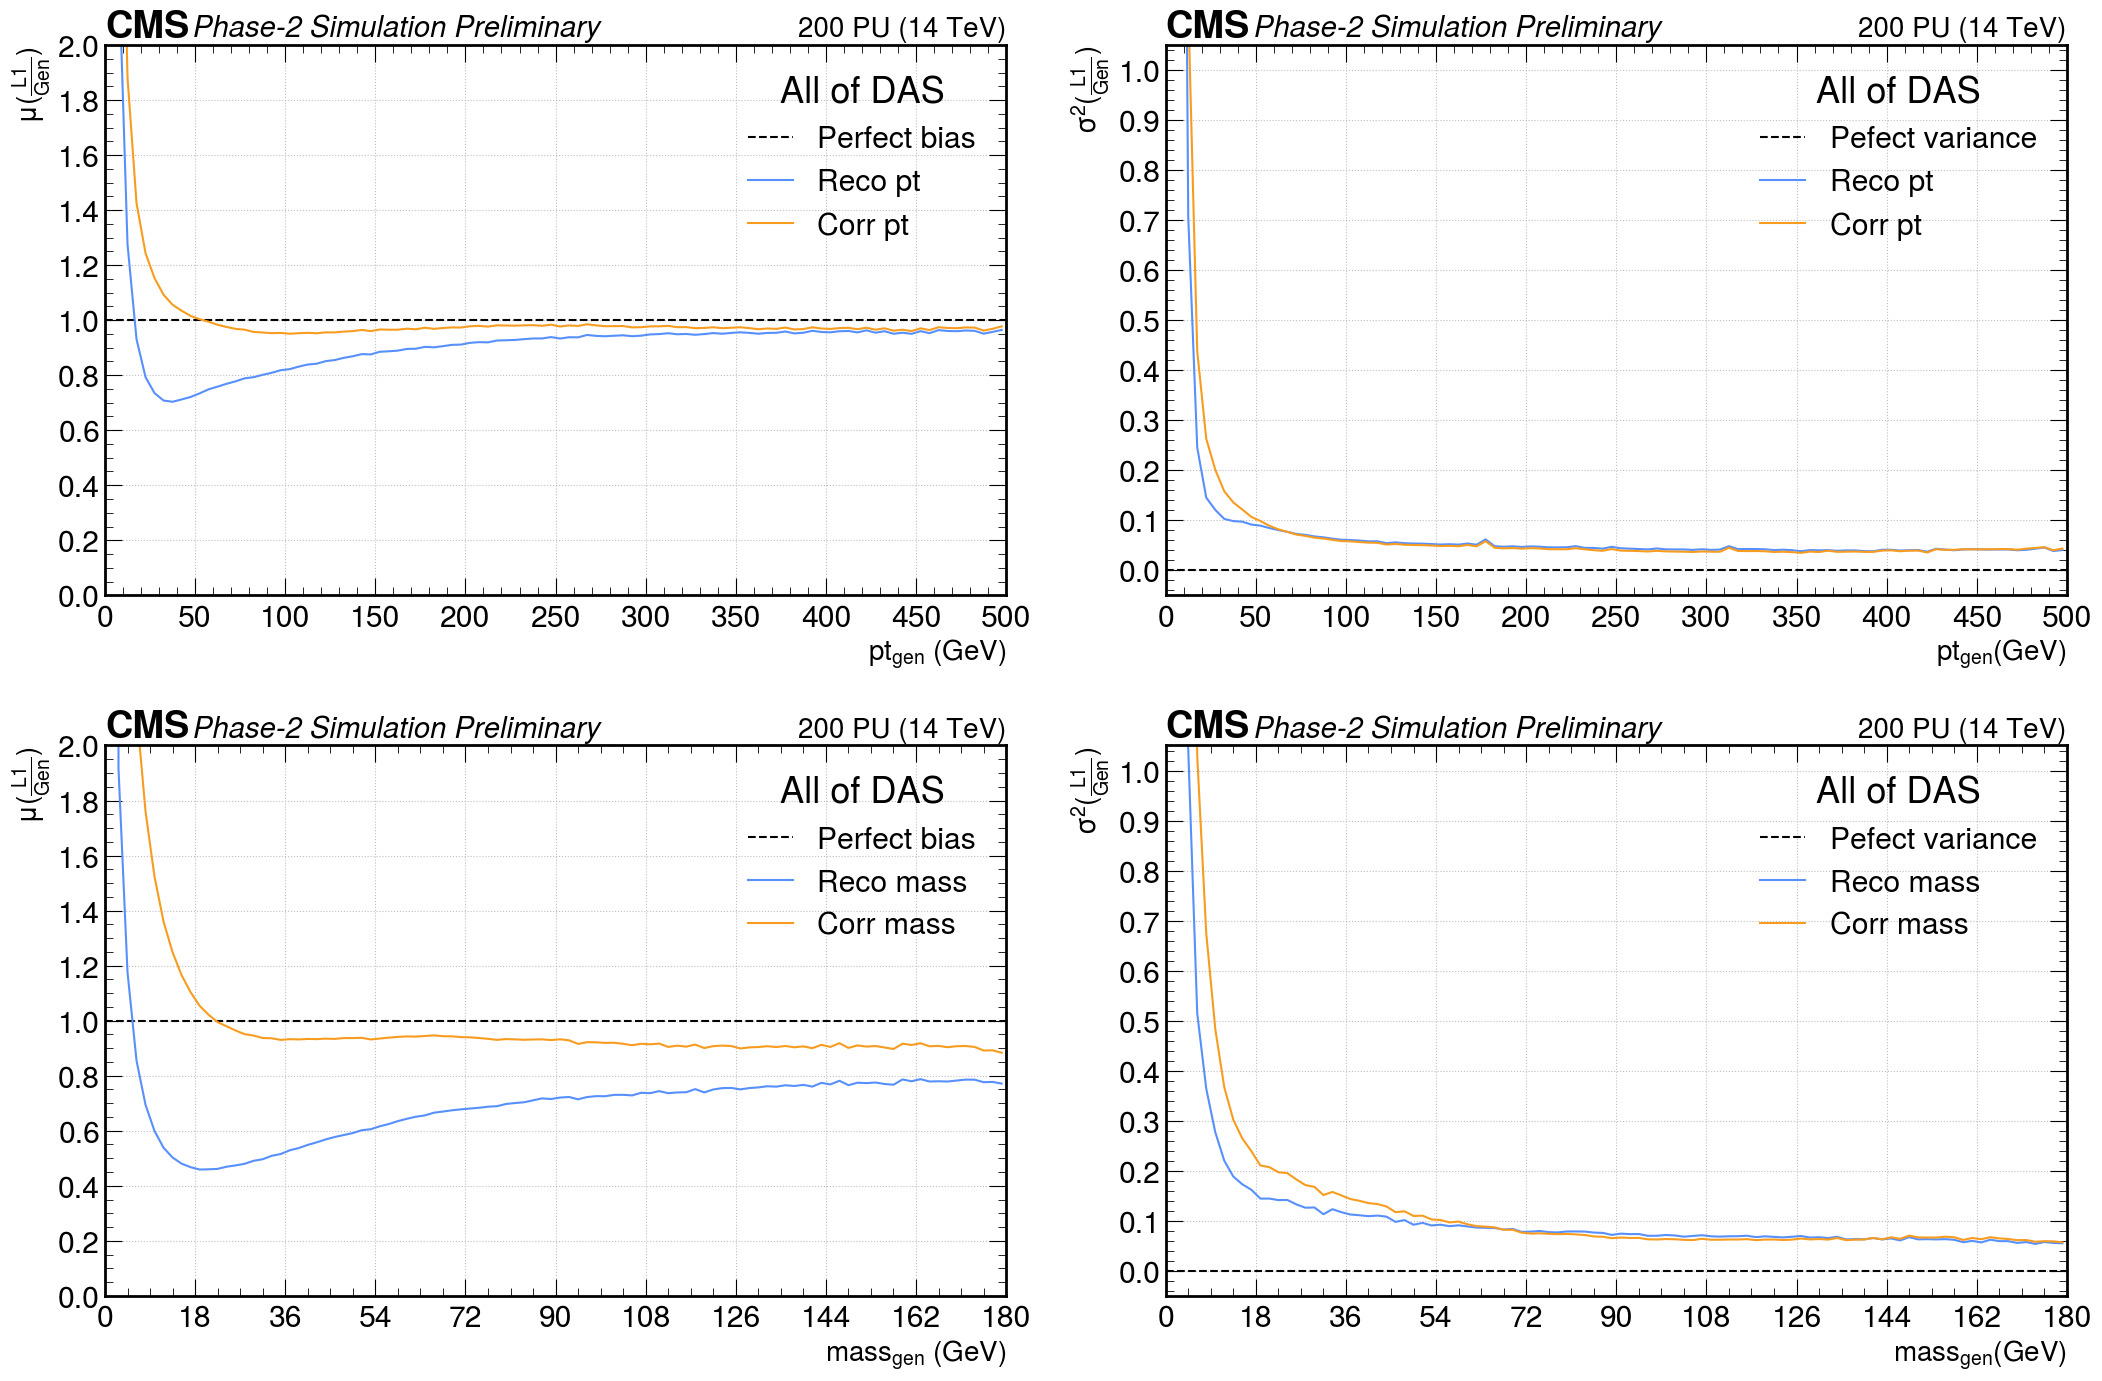

In [191]:
plotResp(test, sample="All of DAS")

# Performance on TT

In [192]:
tt_path = "./data/TT_PU200.root"
tt = Jet(tt_path)
corrs = Jet.apply_scale_factors(tt.data, pt_sfs, mass_sfs, edges)
tt.data["pt_corr"], tt.data["mass_corr"] = corrs[0], corrs[1]

Loading data...


Data loaded!



/dice/users/wq22321/jet_mass_corrections/.env/lib64/python3.9/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/dice/users/wq22321/jet_mass_corrections/.env/lib64/python3.9/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


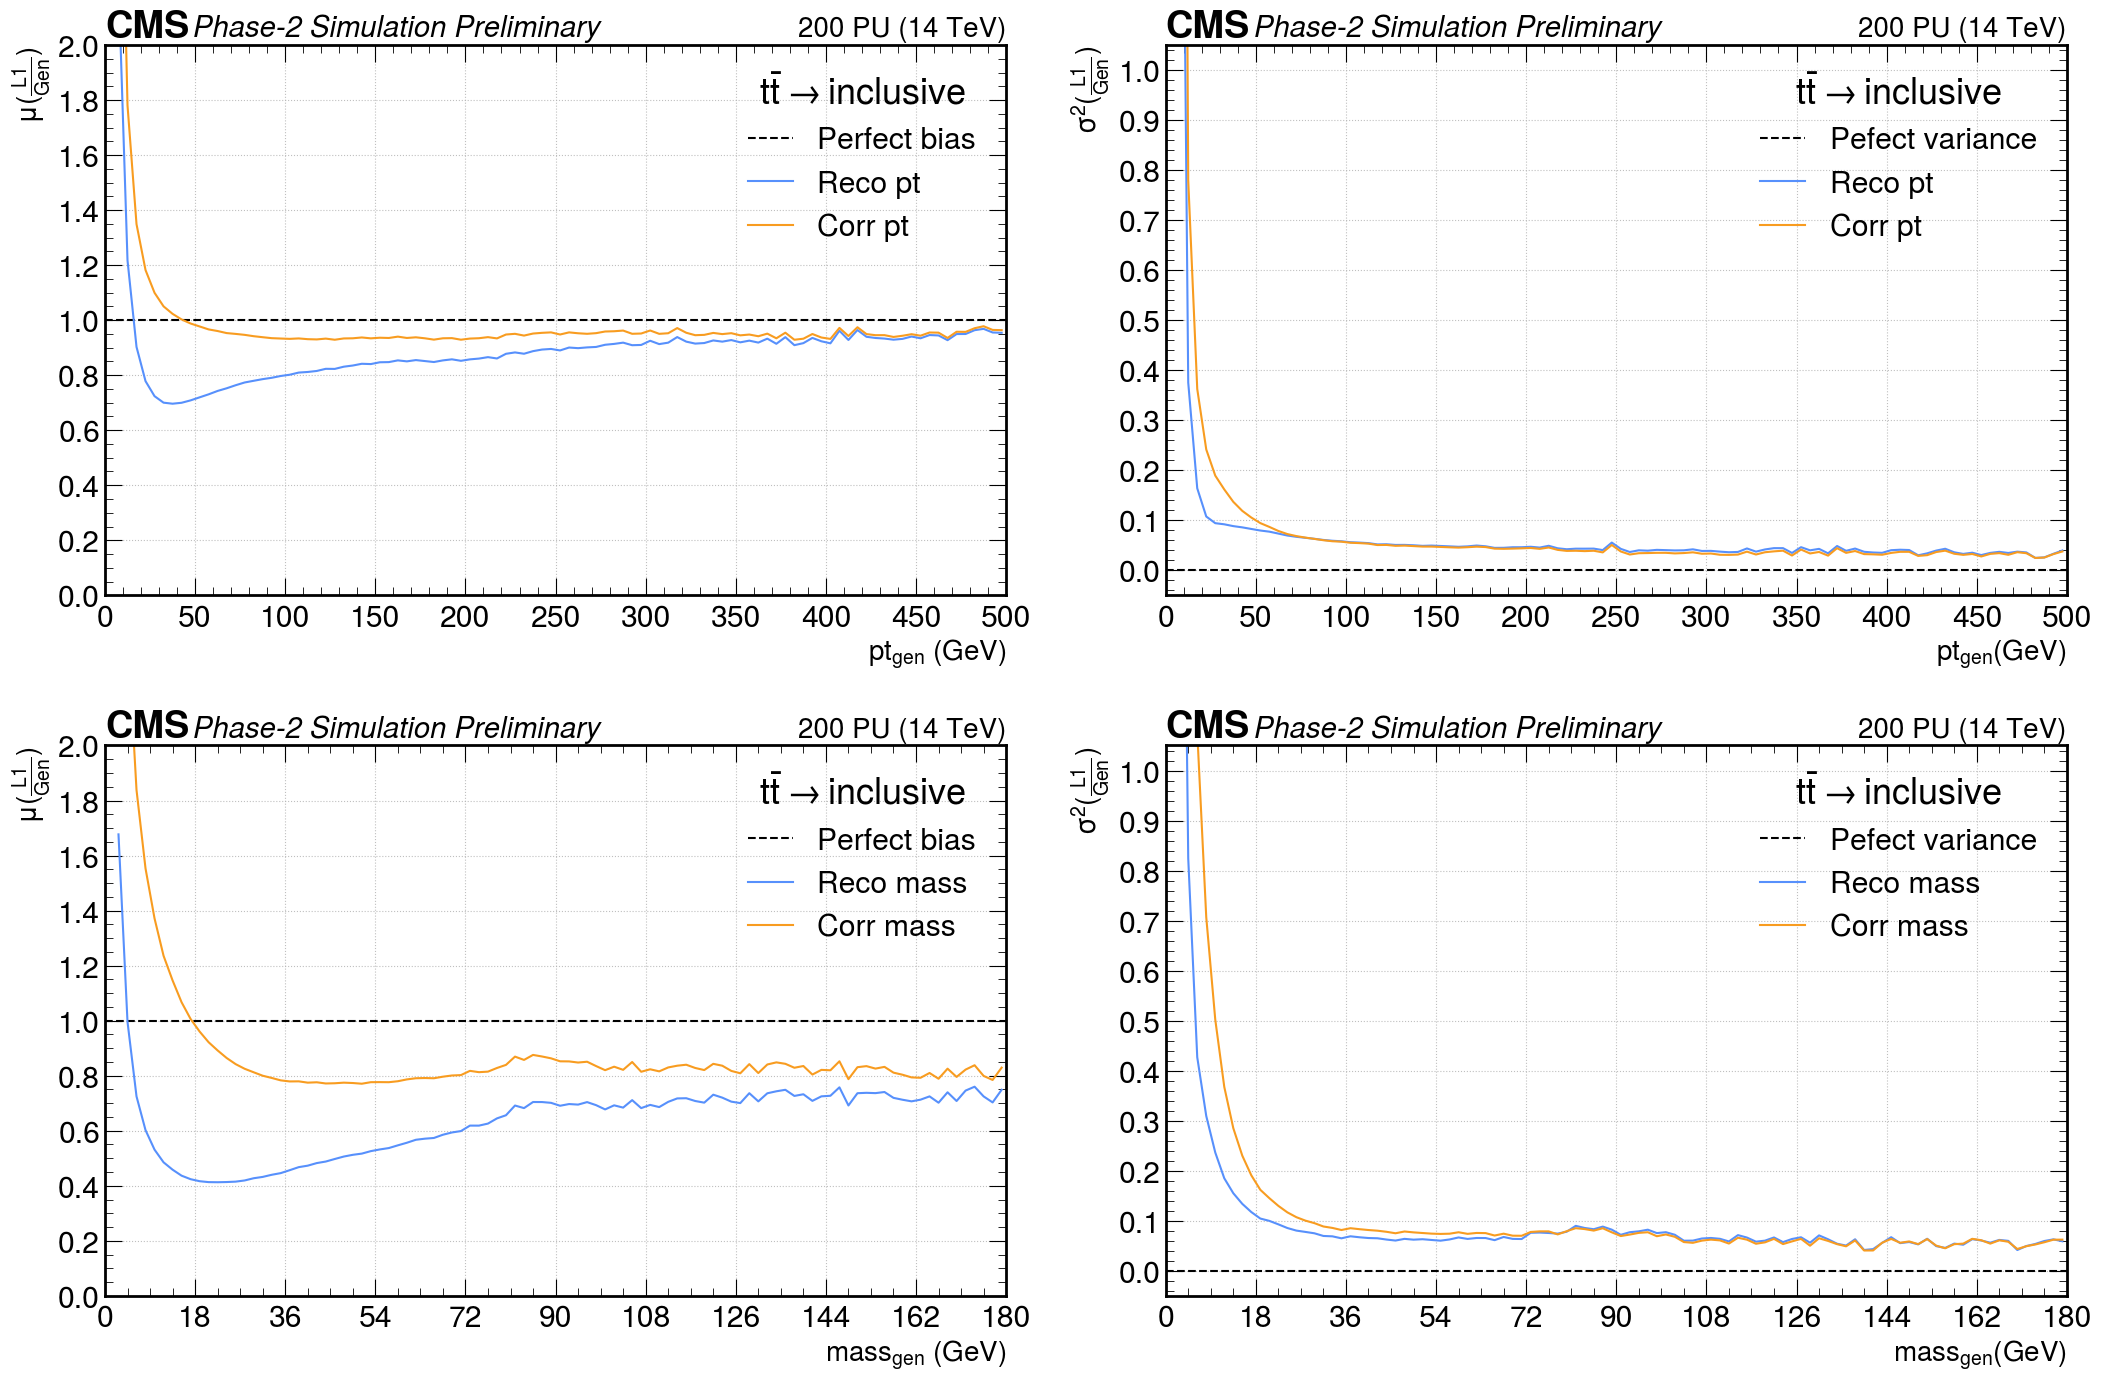

In [193]:
plotResp(tt.data, sample=r"$t\bar{t} \rightarrow \text{inclusive}$")

In [194]:
tt_leading = ak.firsts(Jet.groupby_event(tt.data))
tt_leading_corrs = Jet.apply_scale_factors(tt_leading, pt_sfs, mass_sfs, edges)
tt_leading["pt_corr"], tt_leading["mass_corr"] = tt_leading_corrs[0], tt_leading_corrs[1]

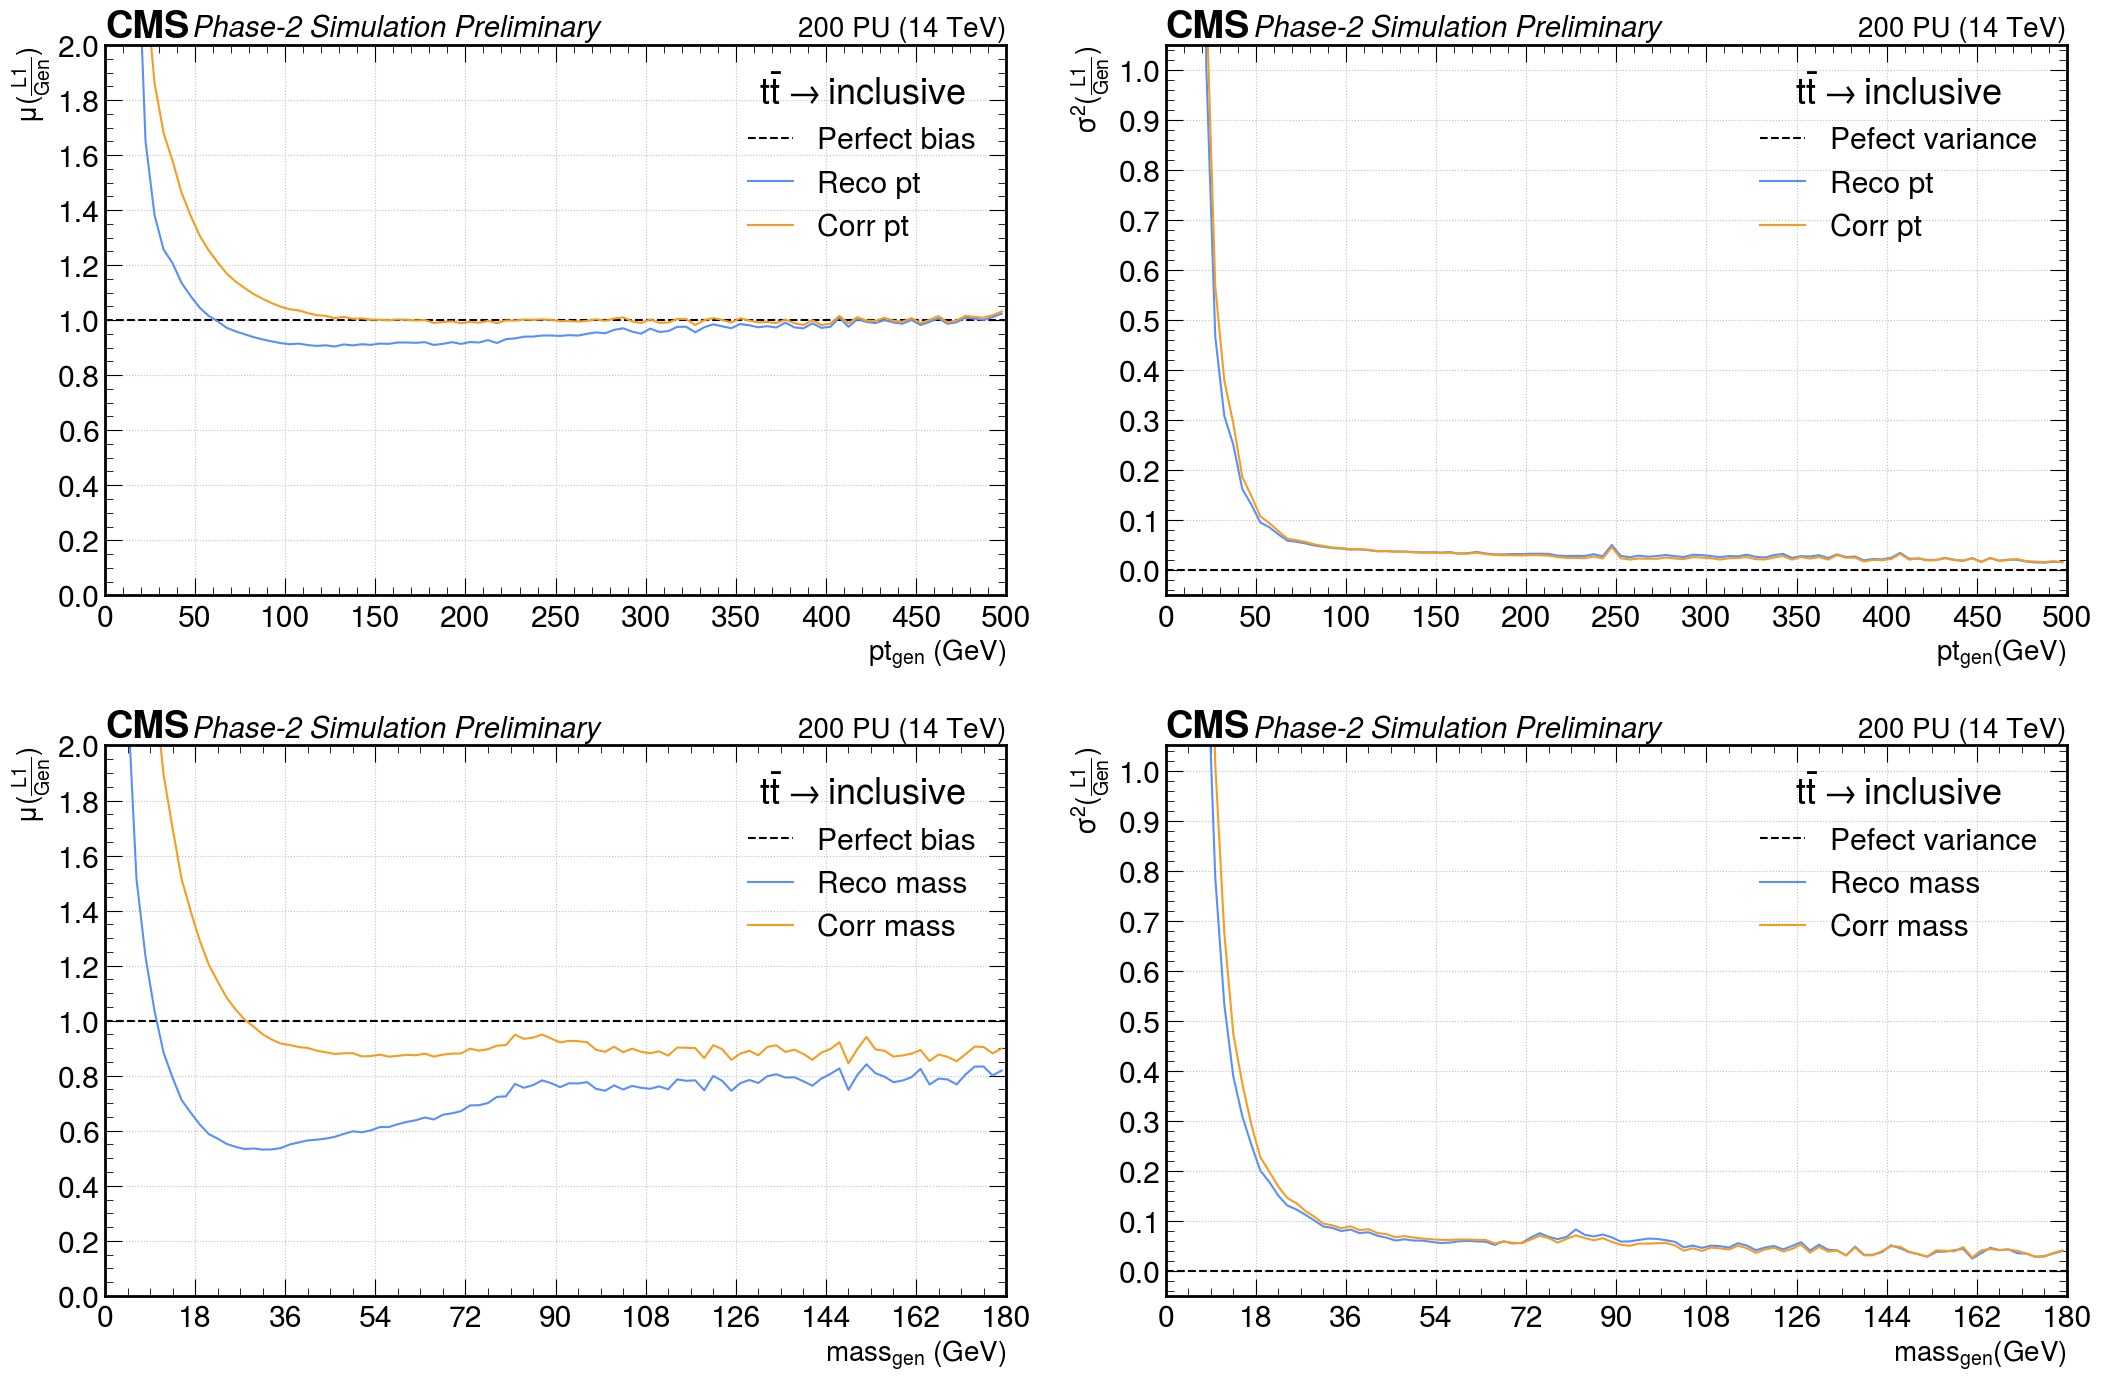

In [195]:
plotResp(tt_leading, sample=r"$t\bar{t} \rightarrow \text{inclusive}$")

# FREFFs

In [196]:
keys = {"L1puppiJetSC8_pt": "pt", "L1puppiJetSC8_eta": "eta", "L1puppiJetSC8_mass": "mass", "L1puppiJetSC8_genpt": "genpt", "L1puppiJetSC8_genmass": "genmass", "event": "event"}
mb_path = "/dice/users/wq22321/jet_mass_DPN/analysis/data/output_Phase2_L1T.root"
mb_jets = Jet(mb_path, branch="Events", keys = keys)
nEvents = len(mb_jets.data)
mb_leading = ak.firsts(mb_jets.data[["pt", "eta", "mass"]])
mb_leading["pt_corr"], mb_leading["mass_corr"] = mb_jets.apply_scale_factors(mb_leading, pt_sfs, mass_sfs, edges)

Loading data...


Data loaded!



In [197]:
def get_rate(bkg_leading, pt_threshold, mass_threshold, nEvents, corrected=False):
    pt_var, mass_var = ("pt_corr", "mass_corr") if corrected else ("pt", "mass")
    passed_mask = (bkg_leading[pt_var] > pt_threshold) & (bkg_leading[mass_var] > mass_threshold)
    K = 40000000 * (2750 / 3564)
    return K * ( ak.sum(passed_mask) / nEvents )

In [198]:
def get_eff(sig_leading, pt_threshold, mass_threshold, corrected=False):
    pt_var, mass_var = ("pt_corr", "mass_corr") if corrected else ("pt", "mass")
    mask = (sig_leading[pt_var] > pt_threshold) & (sig_leading[mass_var] > mass_threshold)
    return ak.sum(mask) / len(sig_leading)

In [199]:
keys = {"L1puppiJetSC8_pt": "pt", "L1puppiJetSC8_eta": "eta", "L1puppiJetSC8_mass": "mass", "L1puppiJetSC8_genpt": "genpt", "L1puppiJetSC8_genmass": "genmass", "event": "event"}
MH40 = "/dice/users/wq22321/jet_mass_DPN/analysis/data/signal/XtoHH_MH-40_qq_PU200_signal.root"
sig_jets = Jet(MH40, branch="Events", keys = keys)
sig_leading = ak.firsts(sig_jets.data[["pt", "eta", "mass", "genpt", "genmass"]])
sig_leading["pt_corr"], sig_leading["mass_corr"] = sig_jets.apply_scale_factors(sig_leading, pt_sfs, mass_sfs, edges)

Loading data...
Data loaded!



In [200]:
from scipy.optimize import differential_evolution as de

# Your objective function
def find_optimum_corr_thresholds(bkg, sig, nEvents, pt_thresh, mass_thresh):
    rate = get_rate(bkg, pt_thresh, mass_thresh, nEvents, corrected=True)
    if rate > 50000:   # penalty for exceeding 50 kHz
        return 0       # any positive value is fine
    else:
        eff = get_eff(sig, pt_thresh, mass_thresh, corrected=True)
        return -eff     # DE minimises, so invert

# Wrapper for DE (must take a single vector argument)
def opti_wrapper(params):
    pt_thresh, mass_thresh = params
    return find_optimum_corr_thresholds(
        mb_leading, sig_leading, nEvents,
        pt_thresh, mass_thresh
    )

# ---- SET BOUNDS ----
# Adjust these depending on your real ranges
pt_bounds = (0, 200)        # e.g. pt threshold from 0–200 GeV
mass_bounds = (0, 50)      # e.g. mass threshold from 0–200 GeV
bounds = [pt_bounds, mass_bounds]

# ---- RUN OPTIMISATION ----
opti_result = de(opti_wrapper, bounds=bounds)

print("Optimisation result:", opti_result)
print("Best pt_thresh:", opti_result.x[0])
print("Best mass_thresh:", opti_result.x[1])
print("Efficiency achieved:", -opti_result.fun * 100, "%")

raw_eff = get_eff(sig_leading, 111, 21, corrected=False)

if raw_eff < -opti_result.fun:
    print("CORRECTIONs RESULT IN IMPROVED L1T EFFICIENCY:")
print(f"Improvement: {(opti_result.fun - raw_eff):.4f}%")

Optimisation result:              message: Optimization terminated successfully.
             success: True
                 fun: -0.7358752166377817
                   x: [ 1.357e+02  3.465e+01]
                 nit: 13
                nfev: 423
          population: [[ 1.357e+02  3.465e+01]
                       [ 1.252e+02  3.699e+01]
                       ...
                       [ 1.192e+02  3.903e+01]
                       [ 1.401e+02  3.367e+01]]
 population_energies: [-7.359e-01 -7.348e-01 ... -7.085e-01 -7.345e-01]
Best pt_thresh: 135.6697754184236
Best mass_thresh: 34.65247505026134
Efficiency achieved: 73.58752166377816 %
Improvement: -1.4849%


In [201]:
from collections import namedtuple
Value = namedtuple("Value", "value error")
def get_turnon(mask, gen, nBins, upperLim=500, equal_frequency=False, custom_bins=None, eta_sep = 100):
    
    if equal_frequency and custom_bins is None:
        _, bins = pd.qcut(gen.to_numpy(allow_missing=True), q=nBins, retbins=True)
        bins[0] = 0
        bins[-1] = upperLim
    elif custom_bins is not None and equal_frequency is False:
        bins = custom_bins
    elif custom_bins is not None and equal_frequency:
        raise Exception("Cannot set both equal_frequency and custom_bins!")
    else:
        bins = np.linspace(0, upperLim, nBins+1)

    effs = []
    for b in range(len(bins)-1):
        inBinMask = (gen >= bins[b]) & (gen < bins[b+1])
        denominator = ak.sum(inBinMask)
        if denominator > 1:
            eff = ak.sum( mask[inBinMask] ) / denominator
            err = np.sqrt(eff * (1 - eff) / denominator)
        else:
            eff = np.float64(0)
            err = np.float64(0)
        effs.append( Value(eff, err) )

    return bins, np.array(effs), np.histogram(gen, int(upperLim/10), range=(0, upperLim))

In [202]:
def plot_turnon(bins, counts, formatting, **effs):
    xs = bins[:-1] + np.diff(bins)/2
    xerrs = np.diff(bins)/2  # symmetric left/right errors
    counts, countBins = counts[0], counts[1]
    widths = np.diff(countBins)
    cents = countBins[:-1] + widths/2
    
    plt.figure(figsize=(15,12))
    plt.bar(cents, 100*counts/max(counts), color="black", alpha=0.1, width=widths)
    for idx, (label, eff) in enumerate(effs.items()):
        plt.errorbar(
            x = xs, y = eff[:, 0]*100, xerr=xerrs, yerr = eff[:, 1]*100,
            fmt="-o", capsize=5, label=formatting[label][0], color=formatting[label][1], markersize=12, linewidth=2, linestyle=formatting[label][2], marker=formatting[label][3]
            )
    
    hep.cms.label(llabel="Phase-2 Simulation Preliminary", rlabel="200 PU (14 TeV)", fontsize=32)
    plt.xlabel(formatting["xlabel"], fontsize=32)
    plt.ylabel(formatting["ylabel"], fontsize=32)
    plt.ylim([-5, 105])
    plt.yticks(np.linspace(0,100,11), fontsize=27)
    plt.xticks(np.linspace(0, bins[-1], 11), fontsize=27)
    plt.legend(loc="center right", title=formatting["sample"], fontsize=27, title_fontsize=32)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.text(x=300, y=3, s = formatting["sample"])
    plt.grid()
    plt.show()

/tmp/ipykernel_1934136/477852017.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(
/tmp/ipykernel_1934136/477852017.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


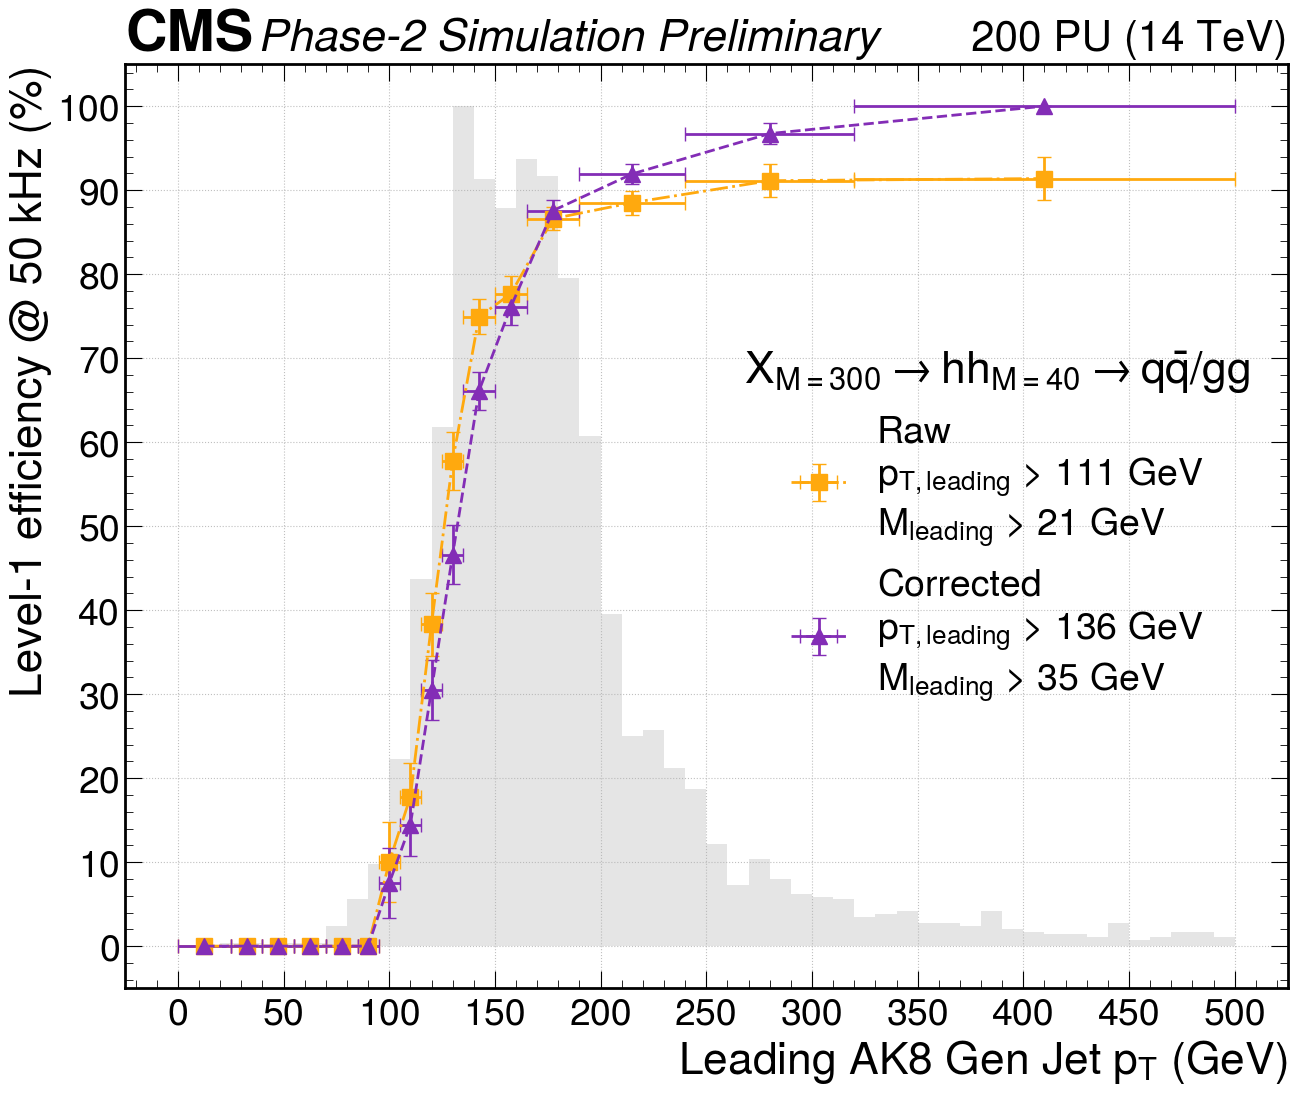

In [203]:
""" SINGLE PF JET - MH40 """
gen = sig_leading["genpt"]
nBins = 16
bins = [0, 25, 40, 55, 70, 85, 95, 105, 115, 125, 135, 150, 165, 190, 240, 320, 500]

labels = {
    "raw": ("Raw\n$p_{T, leading}$ > 111 GeV\n$M_{leading}$ > 21 GeV", "#ffa90e", "dashdot", "s"),
    "corr": ("Corrected\n$p_{{T, leading}}$ > {pt_thresh:.0f} GeV\n$M_{{leading}}$ > {mass_thresh:.0f} GeV".format(pt_thresh=opti_result.x[0], mass_thresh = opti_result.x[1]), "#832db6", "dashed", "^"),

    "xlabel": "Leading AK8 Gen Jet $p_T$ (GeV)",
    "ylabel": "Level-1 efficiency @ 50 kHz (%)",
    "sample": r"$X_{M=300} \rightarrow hh_{M=40} \rightarrow q\bar{q}/gg$"
}

mask_raw = (sig_leading.pt > 111) & (sig_leading.mass > 21)
mask_corr = (sig_leading.pt_corr > opti_result.x[0]) & (sig_leading.mass_corr > opti_result.x[1])

bins, effs_raw, _ = get_turnon(mask_raw, gen, nBins, upperLim=500, equal_frequency=False, custom_bins=bins, eta_sep = 5)
_, effs_corr, _ = get_turnon(mask_corr, gen, nBins, upperLim=500, equal_frequency=False, custom_bins=bins, eta_sep = 5)
plot_turnon(bins, _, labels, raw=effs_raw, corr=effs_corr)